In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Problem 1

To solve for $\sigma_{\nu}^2$ we can decompose the variance of the given return model and find the variance of the transitory component. Then we can use the properties of $u_t = \rho u_{t-1} + \nu_t$ to find $\sigma_u^2$ such that 1/3 of the variance is due to the transitory component. This can be done as follows.

First decompose return variance
$$r_t = p_t - p_{t-1}$$
$$r_t = (p_t^* + u_t) - (p_{t-1}^* + u_{t-1})$$
$$r_t = (p_t^* - p_{t-1}^*) + (u_t - u_{t-1})$$

We can substitute $\epsilon$ for the increment in $p^*$.
$$r_t = \epsilon_t + (u_t - u_t)$$

Now for the variance
$$Var(r_t) = Var(\epsilon_t) + Var(u_t - u_{t-1})$$

We can now solve for the $Var(u_t - u_{t-1})$ component as follows
$$\frac{Var(u_t - u_{t-1})}{Var(r_t)} = 0.25$$

Sub in our derivation of $Var(r_t)$
$$\frac{Var(u_t - u_{t-1})}{Var(\epsilon_t) + Var(u_t - u_{t-1})} = 0.25$$

Plugging in the variance of $\epsilon_t$ and solving for $Var(u_t - u_{t-1})$ we get
$$Var(u_t - u_{t-1}) = \frac{1}{3}$$

To match this variance to our particular process we need to take the variance of the increment of $u_t$ again, but using AR properties to reduce and find $\sigma_u^2$.
$$Var(u_t - u_{t-1}) = Var(u_t) + Var(u_{t-1}) - 2Cov(u_t, u_t-1)$$
$$Var(u_t - u_{t-1}) = 2\sigma_u^2 - 2\rho\sigma_u^2$$
$$Var(u_t - u_{t-1}) = 2\sigma_u^2(1-\rho)$$

Rewrite $\sigma_u^2$ using our unconditional variance formula.
$$Var(u_t - u_{t-1}) = 2\frac{\sigma_{\nu}^2}{1-\rho^2}(1-\rho)$$
$$Var(u_t - u_{t-1}) = 2\frac{\sigma_{\nu}^2}{(1-\rho)(1+\rho)}(1-\rho)$$
$$Var(u_t - u_{t-1}) = \frac{2\sigma_{\nu}^2}{1+\rho}$$
$$\sigma_{\nu}^2 = Var(u_t - u_{t-1})\frac{1+\rho}{2}$$
We can now plug in our results and get the following
$$\sigma_{\nu}^2 = \frac{1.98}{6} \approx 0.33$$

In [29]:
def variance_ratio(data, k):
    one_month_returns = data.var()
    k_month_returns = data.rolling(window=k).sum()
    k_month_returns = k_month_returns.var()
    return k_month_returns / (k * one_month_returns)


def pt_summers_null(T):
    result = [10]
    for _ in range(T):
        result.append(result[-1] + np.random.normal(loc=0, scale=1, size=1)[0])
    result = np.diff(np.array(result))
    return result


def pt_summers(T):
    rho = 0.98
    transitory_variance = 1 / 3
    sigma_nu = np.sqrt(transitory_variance * (1 + rho) / 2)
    p_star = np.zeros(T + 1)
    ut = np.zeros(T + 1)
    epsilon = np.random.normal(loc=0, scale=1, size=T)
    nu = np.random.normal(loc=0, scale=sigma_nu, size=T)
    for i in range(1, T + 1):
        p_star[i] = p_star[i - 1] + epsilon[i - 1]
        ut[i] = rho * ut[i - 1] + nu[i - 1]
    pt = p_star + ut
    rt = np.diff(pt)
    return rt

In [30]:
df = pd.read_csv('crsp_vwretd_1926_2021.csv')
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
df.set_index('date', inplace=True)
k_vals = [12, 24, 36, 48, 60, 90, 120]
actual_var_ratios = pd.DataFrame({k:variance_ratio(df, k) for k in k_vals})
alt_df = pd.DataFrame({f'Sim {i}':pt_summers(len(df)) for i in range(1, 1001)})
null_df = pd.DataFrame({f'Sim {i}':pt_summers_null(len(df)) for i in range(1, 1001)})
null_var_ratios = {}
alt_var_ratios = {}

for k in k_vals:
    null = []
    alt = []
    for col in alt_df.columns:
        null.append(variance_ratio(null_df[col], k))
        alt.append(variance_ratio(alt_df[col], k))
    null_var_ratios[k] = null
    alt_var_ratios[k] = alt


null_var_ratios = pd.DataFrame(null_var_ratios)
alt_var_ratios = pd.DataFrame(alt_var_ratios)

In [31]:
for k in k_vals:
    print(f'For K = {k}')
    null_percent = (null_var_ratios[k] < actual_var_ratios[k].iloc[0]).sum() / len(null_var_ratios[k])
    alt_percent = (alt_var_ratios[k] < actual_var_ratios[k].iloc[0]).sum() / len(alt_var_ratios[k])
    print(f'{actual_var_ratios[k].values[0]} for the data')
    print(f'{null_percent} of the empirical distribution under the null hypothesis is smaller than the point estimate')
    print(f'{alt_percent} of the empirical distribution under the alternative hypothesis is smaller than the point estimate\n')

For K = 12
1.191003133581252 for the data
0.947 of the empirical distribution under the null hypothesis is smaller than the point estimate
0.98 of the empirical distribution under the alternative hypothesis is smaller than the point estimate

For K = 24
1.184548968137181 for the data
0.898 of the empirical distribution under the null hypothesis is smaller than the point estimate
0.944 of the empirical distribution under the alternative hypothesis is smaller than the point estimate

For K = 36
1.0922930591790228 for the data
0.768 of the empirical distribution under the null hypothesis is smaller than the point estimate
0.854 of the empirical distribution under the alternative hypothesis is smaller than the point estimate

For K = 48
0.9971692801012129 for the data
0.618 of the empirical distribution under the null hypothesis is smaller than the point estimate
0.739 of the empirical distribution under the alternative hypothesis is smaller than the point estimate

For K = 60
0.9139054547

# Problem 2

$$y_t = \eta + u_t$$

The distribution does not vary throughout time, it stays exactly the same. The random variable $\eta$ provides a mean for the process, which stays constant for all t, then at each step random noise from $u_t$ is added. Due to $\eta$ not changing and our random noise $u_t$ being i.i.d., the joint distribution between $y_t$ and $y_{t+1}$ is the same as $y_{t+k}$ and $y_{t+k+1}$, making the process strictly stationary.

The first and second moments are as follows.

$$\mathbb{E}[y_t] = \mathbb{E}[\eta] + \mathbb{E}[u_t]$$
$$\mathbb{E}[y_t] = 0 + \frac{1}{2}$$
$$\mathbb{E}[y_t] = \frac{1}{2}$$

$$\mathbb{E}[y_t^2] = Var(y_t) + \mathbb{E}[y_t]^2$$
$$Var(y_t) = Var(\eta) + Var(u_t) - 2Cov(\eta, u_t)$$
$$Var(y_t) = 1 + \frac{1}{12}$$
$$Var(y_t) = \frac{13}{12}$$
$$\mathbb{E}[y_t^2] = \frac{13}{12} + \frac{1}{4}$$
$$\mathbb{E}[y_t^2] = \frac{4}{3}$$

The autocovariance is as follows
$$Cov(y_t, y_{t-1}) = \mathbb{E}[y_t * y_{t-1}] - \mu_t * \mu_{t-1}$$
$$Cov(y_t, y_{t-1}) = \mathbb{E}[y_t * y_{t-1}] - \frac{1}{4}$$
$$Cov(y_t, y_{t-1}) = \mathbb{E}[y_t] * \mathbb{E}[y_{t-1}] - \frac{1}{4}$$
$$Cov(y_t, y_{t-1}) = \frac{1}{4} - \frac{1}{4}$$
$$Cov(y_t, y_{t-1}) = 0$$

This process is not ergodic as our sample mean depends on our draw of $\eta$. Over time the process will not converge to the theoretical mean of $\frac{1}{2}$, it will converge to whatever the draw of $\eta$ is. Furthermore, the longer term dynamics of the sample don't give more information about the mean of the process, only $\eta$. We can run some simulations to confirm our numbers.

In [32]:
def stochastic_process(iterations):
    eta = np.random.normal(loc=0, scale=1, size=1)[0]
    u = np.random.uniform(low=0, high=1, size=iterations)
    return (eta + u), eta


def autocovariance(process, lag):
    process = pd.Series(process)
    return process.cov(process.shift(lag))

In [33]:
sim, draw = stochastic_process(100000)
t = np.linspace(0, 1, num=len(sim))

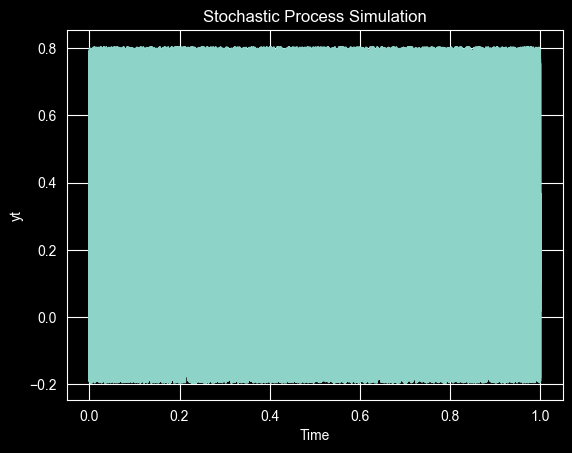

In [34]:
sns.lineplot(x=t, y=sim)
plt.xlabel('Time')
plt.ylabel('yt')
plt.title('Stochastic Process Simulation')
plt.show()

In [35]:
print(f'Eta Draw = {draw}')
print(f'Mu = {np.mean(sim)}')
print(f'Second Moment = {sum(val**2 for val in sim) / len(sim)}')

Eta Draw = -0.1961914450351793
Mu = 0.3028071551194389
Second Moment = 0.17482814787852766


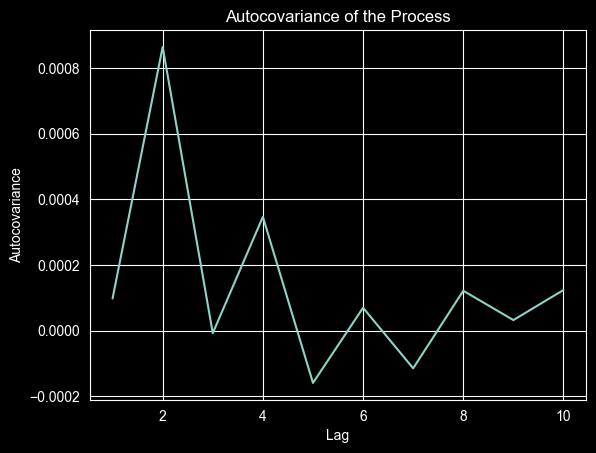

In [36]:
auto_cov = {i:autocovariance(sim, i) for i in range(1, 11, 1)}
sns.lineplot(x=auto_cov.keys(), y=auto_cov.values())
plt.title('Autocovariance of the Process')
plt.ylabel('Autocovariance')
plt.xlabel('Lag')
plt.show()